David BM ®


In [5]:
%%capture

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [6]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [7]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import json
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog




### prepare the dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd "/content/drive/MyDrive/PhD"

/content/drive/MyDrive/PhD


In [10]:
data_root_path = "./Kaggle_teeth_dataset/input/teeth-segmentation-on-dental-x-ray-images"
json_files_path=data_root_path+"/Teeth Segmentation JSON/d2/ann"

In [11]:
from detectron2.structures import BoxMode

def convert_to_coco_format(data, filename,image_id, image_width, image_height):
    """
    Convert data from the given format to COCO format.

    Args:
        data (dict): The annotation data in the given format.
        image_id (int): The unique ID of the image. (file name)
        image_width (int): Width of the image.
        image_height (int): Height of the image.

    Returns:
        coco_annotations (dict): Data in COCO annotation format.
    """

    record = {}
    annotation_id = 1

    record["file_name"] = filename
    record["image_id"] = image_id
    record["height"] = image_height
    record["width"] = image_width

    objs = []
    # Loop through each object in the JSON data
    for obj in data.get("objects", []):
        points = obj.get("points", {}).get("exterior", [])
        if not points:
            continue

        # Flatten points for segmentation
        segmentation = [coord for point in points for coord in point]

        # Calculate bbox: [x_min, y_min, width, height]
        x_coords, y_coords = zip(*points)
        x_min, y_min = min(x_coords), min(y_coords)
        x_max, y_max = max(x_coords), max(y_coords)
        bbox = [x_min, y_min, x_max, y_max]

        # Create annotation in COCO format
        annotation = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": int(obj["classTitle"]),  # Assuming 'classTitle' is the class ID
            "segmentation": [segmentation],
            "bbox": bbox,
            "bbox_mode": BoxMode.XYXY_ABS,
            "iscrowd": 0
        }

        objs.append(annotation)
        annotation_id += 1

    record["annotations"] = objs
    return record




In [12]:
# Get a list of all json files in the json directory
json_files = [f for f in os.listdir(json_files_path) if f.endswith('.json')]

dataset_dicts=[] # list  of dictionaries each one represent json file with coco format
for json_file in json_files:
  # Convert the  JSON to COCO format
  image_id =json_file.split(".")[0]
  filename=image_id+".jpg"
  json_path = os.path.join(json_files_path, json_file)
  with open(json_path, 'r') as file:
      data = json.load(file)
      size=data.get("size",[])
      image_height=size['height']
      image_width=size['width']
      record = convert_to_coco_format(data,filename, image_id, image_width, image_height)
      dataset_dicts.append(record)

In [13]:
# now we split the  dataset_dicts to train and val groups

train_images_path="./Kaggle_teeth_dataset/working/train"
valid_images_path="./Kaggle_teeth_dataset/working/valid"
train_images_nums,val_images_nums=[],[]
train_dir=os.listdir(train_images_path)
val_dir=os.listdir(valid_images_path)
for file in val_dir:
  val_images_nums.append(file.split(".")[0])
for file in train_dir:
  train_images_nums.append(file.split(".")[0])

train_coco_files=[]
val_coco_files=[]

for dic in dataset_dicts:
  if len(dic)==0:
    continue
  if dic['image_id'] in train_images_nums:
    dic['file_name']=train_images_path+"/"+dic['file_name']
    train_coco_files.append(dic)
  else:
    dic['file_name']=valid_images_path+"/"+dic['file_name']
    val_coco_files.append(dic)


In [14]:
train_coco_files[0]['file_name']

'./Kaggle_teeth_dataset/working/train/1.jpg'

In [15]:
# in this step we get the numbers of classes from the meta.json file
meta_path=data_root_path+"/Teeth Segmentation JSON/meta.json"
num_of_classes=0
lst_of_classes=[]
with open(meta_path, 'r') as file:
    meta_data = json.load(file)
    classes=meta_data['classes']
    for cls in classes:
      lst_of_classes.append(cls['title'])
      num_of_classes+=1

In [16]:
'''
DatasetCatalog.remove("teeth_train")
DatasetCatalog.remove("teeth_val")
MetadataCatalog.remove("teeth_train")
MetadataCatalog.remove("teeth_val")
'''

'\nDatasetCatalog.remove("teeth_train")\nDatasetCatalog.remove("teeth_val")\nMetadataCatalog.remove("teeth_train")\nMetadataCatalog.remove("teeth_val")\n'

In [17]:
# register the following datatset
from detectron2.data import MetadataCatalog, DatasetCatalog

DatasetCatalog.register("teeth_train", lambda: train_coco_files)
DatasetCatalog.register("teeth_val", lambda: val_coco_files)
MetadataCatalog.get("teeth_train").set(thing_classes=lst_of_classes)
MetadataCatalog.get("teeth_val").set(thing_classes=lst_of_classes)
teeth_metadata = MetadataCatalog.get("teeth_train")


visualization of one image

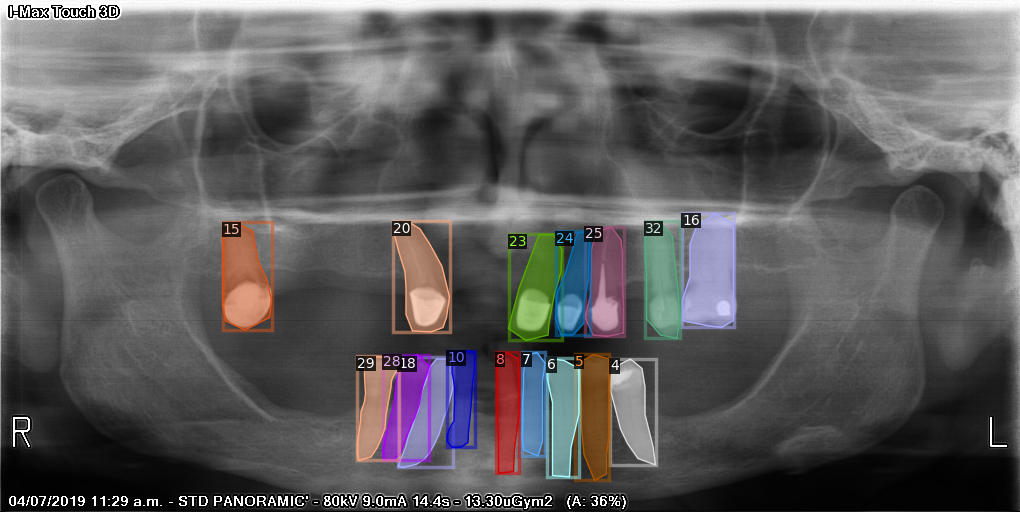

In [18]:
train_img_id=train_dir[0].split(".")[0]
train_img_details=""
for dic in train_coco_files:
  if dic['image_id']==train_img_id:
    train_img_details=dic
    break

image_path=train_images_path+"/"+train_dir[0]
img =cv2.imread(image_path)
visualizer = Visualizer(img[:, :, ::-1], metadata=teeth_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(train_img_details)
cv2_imshow(out.get_image()[:, :, ::-1])


## Training

In [19]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("teeth_train",)
cfg.DATASETS.TEST = ("teeth_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 32
cfg.INPUT.MASK_FORMAT = "bitmask"


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/05 07:55:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 104MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/05 07:55:17 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/05 07:55:41 d2.utils.events]:  eta: 0:09:19  iter: 19  total_loss: 6.666  loss_cls: 3.528  loss_box_reg: 0.6996  loss_mask: 0.693  loss_rpn_cls: 1.501  loss_rpn_loc: 0.191    time: 0.5797  last_time: 0.6243  data_time: 0.1048  last_data_time: 0.0473   lr: 4.9953e-06  max_mem: 2582M
[09/05 07:55:58 d2.utils.events]:  eta: 0:09:04  iter: 39  total_loss: 5.381  loss_cls: 3.427  loss_box_reg: 0.7748  loss_mask: 0.6931  loss_rpn_cls: 0.3109  loss_rpn_loc: 0.1554    time: 0.5822  last_time: 0.6021  data_time: 0.0497  last_data_time: 0.0419   lr: 9.9902e-06  max_mem: 2582M
[09/05 07:56:11 d2.utils.events]:  eta: 0:09:10  iter: 59  total_loss: 4.967  loss_cls: 3.189  loss_box_reg: 0.8121  loss_mask: 0.6927  loss_rpn_cls: 0.09127  loss_rpn_loc: 0.1569    time: 0.6035  last_time: 0.5857  data_time: 0.0554  last_data_time: 0.0184   lr: 1.4985e-05  max_mem: 2583M
[09/05 07:56:24 d2.utils.events]:  eta: 0:08:59  iter: 79  total_loss: 4.564  loss_cls: 2.81  loss_box_reg: 0.8438  loss_mask: 0.692

In [20]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[09/05 08:06:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

visualization of the predection of one image from vaildation group

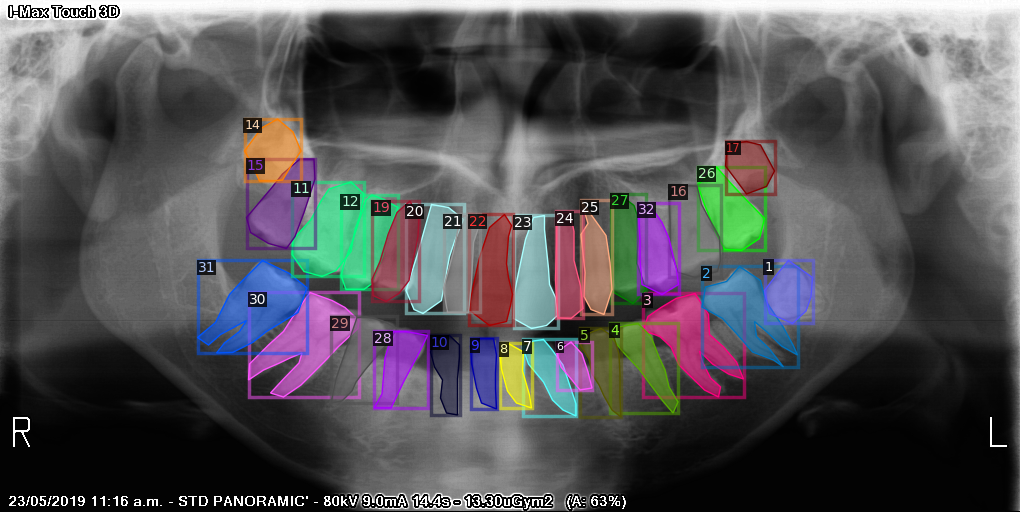

In [21]:
val_img_id=val_dir[0].split(".")[0]
val_img_details=""
for dic in val_coco_files:
  if dic['image_id']==val_img_id:
    val_img_details=dic
    break


image_path=valid_images_path+"/"+val_dir[0]
img =cv2.imread(image_path)
val_teeth_metadata=MetadataCatalog.get("teeth_val")
visualizer = Visualizer(img[:, :, ::-1], metadata=val_teeth_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(val_img_details)
cv2_imshow(out.get_image()[:, :, ::-1])

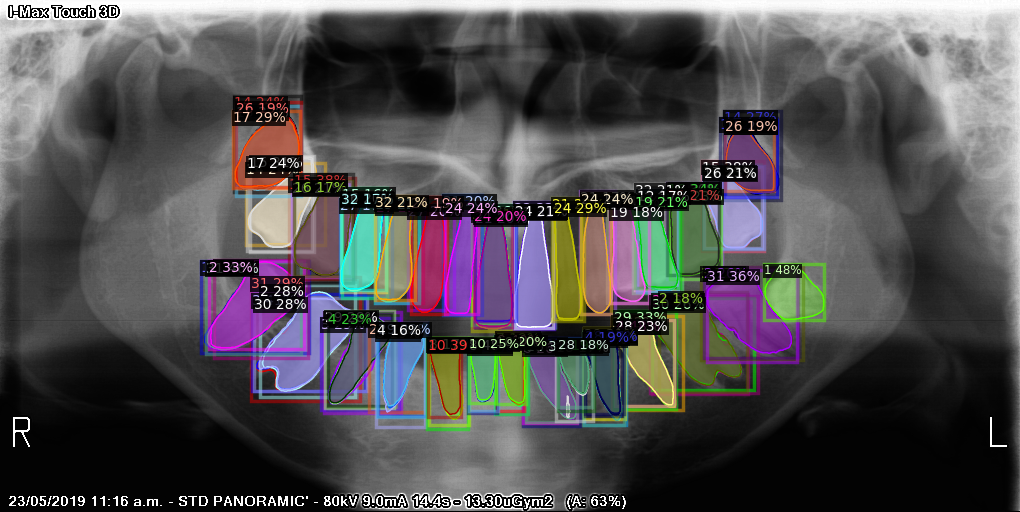

In [22]:
from detectron2.utils.visualizer import ColorMode

image_path=valid_images_path+"/"+val_dir[0]
img =cv2.imread(image_path)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
                   metadata=val_teeth_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels.
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [23]:
def calculate_bbox_area(bbox):
    """
    Calculate the area of a bounding box.

    Parameters:
    bbox (list or tuple): A list or tuple containing four values [x1, y1, x2, y2],
                          where (x1, y1) are the coordinates of the top-left corner,
                          and (x2, y2) are the coordinates of the bottom-right corner.

    Returns:
    float: The area of the bounding box.
    """
    x1, y1, x2, y2 = bbox

    # Calculate the width and height of the bounding box
    width = x2 - x1
    height = y2 - y1

    # Calculate the area
    area = width * height

    return area


In [24]:
def calculate_intersection_area(bbox1, bbox2):
    """
    Calculate the intersection area between two bounding boxes.

    Parameters:
    bbox1, bbox2 (list or tuple): Bounding boxes in the format [x1, y1, x2, y2].

    Returns:
    float: The intersection area of the two bounding boxes.
    """
    x1_inter = max(bbox1[0], bbox2[0])
    y1_inter = max(bbox1[1], bbox2[1])
    x2_inter = min(bbox1[2], bbox2[2])
    y2_inter = min(bbox1[3], bbox2[3])

    # Calculate width and height of the intersection
    width_inter = max(0, x2_inter - x1_inter)
    height_inter = max(0, y2_inter - y1_inter)

    return width_inter * height_inter

In [25]:
def match_bboxes(real_bboxes, pred_bboxes):
    """
    Match real bounding boxes with predicted bounding boxes that intersect
    more than 80% of the real bounding box area.

    Parameters:
    real_bboxes (list): List of real bounding boxes dictionaries,
    pred_bboxes (list): List of predicted bounding boxes dictionaries,

    Returns:
    list: A list of dictionaries where each dic contains a real bounding box and a list
          of predicted bounding boxes that intersect more than 80% of its area.
    """
    matched_bboxes = []

    for real_bbox in real_bboxes:
        real_area = real_bbox['real_bbox_area']
        matched_preds = []
        inter_ratios=[]

        for pred_bbox in pred_bboxes:
            inter_area = calculate_intersection_area(real_bbox['bbox'], pred_bbox['bbox'])

            if inter_area >= 0.9 * real_area:
                matched_preds.append(pred_bbox)
                inter_ratios.append(inter_area/real_area)

        teeth={}
        teeth['real_catagories']=real_bbox['category']
        for i in range(len(matched_preds)):
          teeth['pred_catagories '+str(i+1)]=matched_preds[i]['category']
          teeth['pred_score '+str(i+1)]=f"{matched_preds[i]['score']:.2f}"
          teeth['inter_ratio '+str(i+1)]=f"{inter_ratios[i]:.2f}"
        matched_bboxes.append(teeth)

    return matched_bboxes

In [26]:
#create list of real bbox with additional information
real_bboxes=[]
annotations=val_img_details
for i in range(len(annotations['annotations'])):
  real_bbox={}
  real_bbox['bbox']=annotations['annotations'][i]['bbox']
  real_bbox['category']=annotations['annotations'][i]['category_id']
  real_bbox['real_bbox_area']=calculate_bbox_area(annotations['annotations'][i]['bbox'])
  real_bboxes.append(real_bbox)

In [27]:
#create list of predicted bbox with additional information
pred_bboxes=[]
pred_boxes=outputs["instances"].pred_boxes.to("cpu")
pred_classes=outputs["instances"].pred_classes.to("cpu")
scores=outputs["instances"].scores.to("cpu")
assert len(pred_boxes)==len(pred_classes)==len(scores)
for i in range(len(pred_boxes)):
  pred_bbox={}
  pred_bbox['bbox']=pred_boxes[i].tensor.tolist()[0]
  pred_bbox['category']=pred_classes[i].item()
  pred_bbox['score']=scores[i].item()
  pred_bbox['pred_bbox_area']=pred_boxes[i].area().tolist()
  pred_bboxes.append(pred_bbox)

In [28]:
  pred_bboxes

[{'bbox': [1299.5076904296875,
   591.8798828125,
   1516.317138671875,
   785.442626953125],
  'category': 19,
  'score': 0.5381140112876892,
  'pred_bbox_area': [41966.23046875]},
 {'bbox': [1231.4088134765625,
   639.6869506835938,
   1350.5880126953125,
   812.6813354492188],
  'category': 20,
  'score': 0.4848933219909668,
  'pred_bbox_area': [20617.33203125]},
 {'bbox': [937.3590698242188,
   678.1869506835938,
   995.3394775390625,
   821.04345703125],
  'category': 24,
  'score': 0.48278969526290894,
  'pred_bbox_area': [8282.87890625]},
 {'bbox': [1527.333984375,
   528.9815673828125,
   1648.8519287109375,
   640.56298828125],
  'category': 17,
  'score': 0.4824776351451874,
  'pred_bbox_area': [13559.14453125]},
 {'bbox': [411.5341796875,
   523.4149169921875,
   602.3905639648438,
   708.8135986328125],
  'category': 31,
  'score': 0.4572201073169708,
  'pred_bbox_area': [35384.5234375]},
 {'bbox': [504.2993469238281,
   587.1836547851562,
   730.61083984375,
   781.1212768

In [29]:
#cheak similarities between predicted and real bboxes
matched_bboxes=match_bboxes(real_bboxes,pred_bboxes)

In [30]:
matched_bboxes[0]

{'real_catagories': 1,
 'pred_catagories 1': 2,
 'pred_score 1': '0.32',
 'inter_ratio 1': '1.00',
 'pred_catagories 2': 16,
 'pred_score 2': '0.29',
 'inter_ratio 2': '0.98',
 'pred_catagories 3': 1,
 'pred_score 3': '0.24',
 'inter_ratio 3': '1.00',
 'pred_catagories 4': 15,
 'pred_score 4': '0.19',
 'inter_ratio 4': '1.00'}

In [31]:
#outputs["instances"]

## Evaluation

 show evaluation metrics (include average precsion) on the validation images

In [32]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("teeth_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "teeth_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[09/05 08:06:50 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[09/05 08:06:50 d2.evaluation.coco_evaluation]: Trying to convert 'teeth_val' to COCO format ...
WARNING [09/05 08:06:50 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/teeth_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[09/05 08:06:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/05 08:06:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/05 08:06:51 d2.data.common]: Serializing 90 elements to byte tensors and concatenating them all ...
[09/05 08:06:51 d2.data.common]: Serialized dataset takes 0.34 MiB
[09/05 08:06:51 d2.evaluation.evaluator]: Start inference on 90 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/05 08:07:01 d2.evaluation.evaluator]: Inference done 11/90. Dataloading: 0.0017 s/iter. Inference: 0.1802 s/iter. Eval: 0.6615 s/iter. Total: 0.8434 s/iter. ETA=0:01:06
[09/05 08:07:06 d2.evaluation.evaluator]: Inference done 17/90. Dataloading: 0.0025 s/iter. Inference: 0.1875 s/iter. Eval: 0.6815 s/iter. Total: 0.8718 s/iter. ETA=0:01:03
[09/05 08:07:12 d2.evaluation.evaluator]: Inference done 23/90. Dataloading: 0.0033 s/iter. Inference: 0.1848 s/iter. Eval: 0.7115 s/iter. Total: 0.8999 s/iter. ETA=0:01:00
[09/05 08:07:17 d2.evaluation.evaluator]: Inference done 29/90. Dataloading: 0.0037 s/iter. Inference: 0.1840 s/iter. Eval: 0.7046 s/iter. Total: 0.8929 s/iter. ETA=0:00:54
[09/05 08:07:23 d2.evaluation.evaluator]: Inference done 35/90. Dataloading: 0.0039 s/iter. Inference: 0.1838 s/iter. Eval: 0.7021 s/iter. Total: 0.8904 s/iter. ETA=0:00:48
[09/05 08:07:28 d2.evaluation.evaluator]: Inference done 43/90. Dataloading: 0.0035 s/iter. Inference: 0.1813 s/iter. Eval: 0.6537 s/it

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/05 08:08:06 d2.evaluation.evaluator]: Total inference time: 0:01:10.331919 (0.827434 s / iter per device, on 1 devices)
[09/05 08:08:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:15 (0.180981 s / iter per device, on 1 devices)
[09/05 08:08:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/05 08:08:08 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/05 08:08:09 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.97s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.199
 Average

## images segmentation

now we evaluate the model on the mask images

In [33]:
#@title create black and white masks for each images
def is_directory_not_empty(directory_path):
    return any(os.scandir(directory_path))

def json_to_mask(json_folder, output_folder, image_shape):
    # List all files in the json folder
    json_files = [f for f in os.listdir(json_folder) if f.endswith('.json')]

    for json_file in json_files:
        json_path = os.path.join(json_folder, json_file)

        # Read JSON file
        with open(json_path, 'r') as file:
            data = json.load(file)

        # Extract the coordinates
        # Assuming data has the format {'objects': [{'points': {'exterior': [[x1, y1], [x2, y2], ...]}}, ...]}
        coordinates = []
        for obj in data.get('objects', []):
            if 'points' in obj and 'exterior' in obj['points']:
                coordinates.append(np.array(obj['points']['exterior'], dtype=np.int32))

        # Create a white mask image
        mask = np.ones(image_shape, dtype=np.uint8) * 255

        # Draw each object with a thin line around it
        for polygon in coordinates:
            cv2.fillPoly(mask, [polygon], color=(0))  # Fill the inside of the polygon with black
            cv2.polylines(mask, [polygon], isClosed=True, color=(255), thickness=3)  # Draw the border of the polygon in white

        # Invert colors
        mask = cv2.bitwise_not(mask)

        # Save the mask image
        mask_filename = os.path.splitext(os.path.splitext(json_file)[0])[0]  # Get the base name without any extension
        mask_path = os.path.join(output_folder, mask_filename + ".jpg")
        cv2.imwrite(mask_path, mask)


# Create directories for output masks
output_folder = './Kaggle_teeth_dataset/working/masks'
os.makedirs(output_folder, exist_ok=True)

# Convert JSON files to masks
json_folder = './Kaggle_teeth_dataset/input/teeth-segmentation-on-dental-x-ray-images/Teeth Segmentation JSON/d2/ann'
image_shape = (1024, 2041)

if not(is_directory_not_empty(output_folder)):
    json_to_mask(json_folder, output_folder, image_shape)




In [34]:
def dice_score(predict_mask,original_mask):
  # Compute the Dice score
  intersection = np.sum(predict_mask * original_mask)
  ds = (2.0 * intersection) / (np.sum(predict_mask) + np.sum(original_mask))
  return ds


In [35]:
# grouped all the masks related to validation images in one list
mask_nums = [f.split('.')[0] for f in os.listdir(output_folder)]
mask_imgs_val=[img_num+".jpg"  for img_num in mask_nums if img_num in val_images_nums]
mask_imgs_val_paths = [os.path.join(output_folder,img) for img in mask_imgs_val]


compute dice score to the validation group

In [36]:

# Visualization function
def visualize_predictions(image, ground_truth, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(ground_truth, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(prediction, cmap='gray')
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


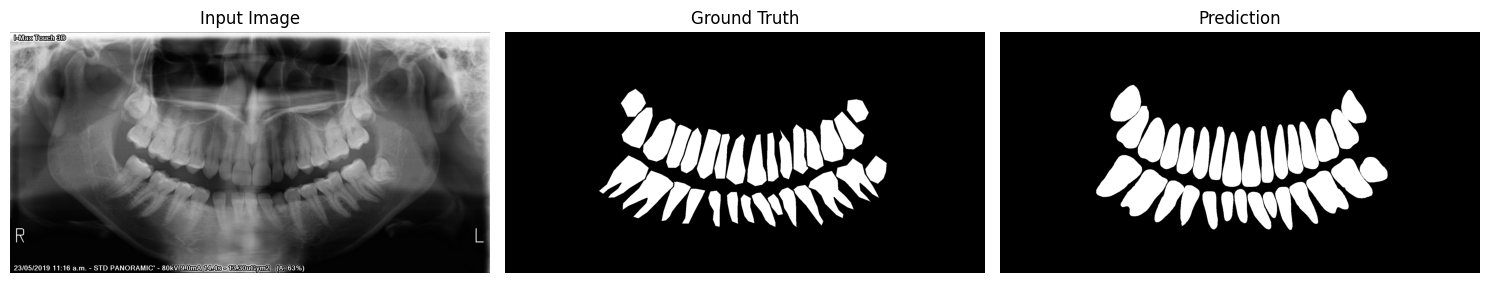

dice score 0.8663652165070972


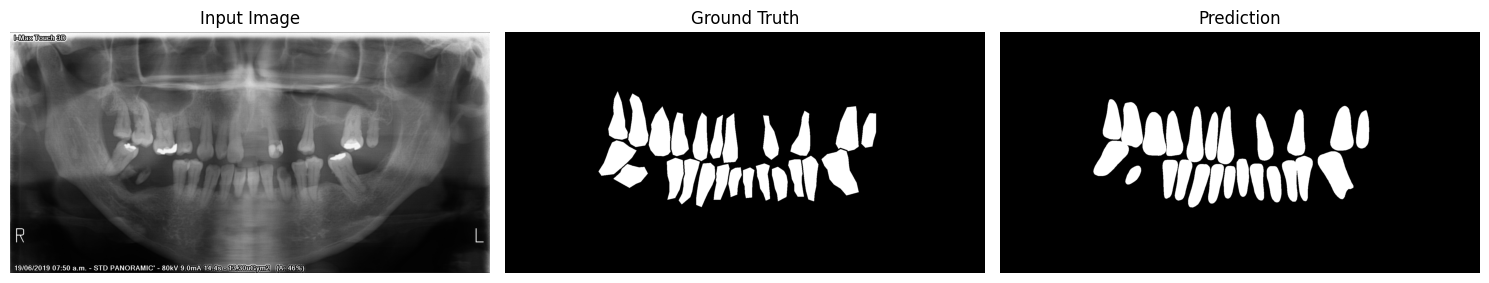

dice score 0.8779661091462222


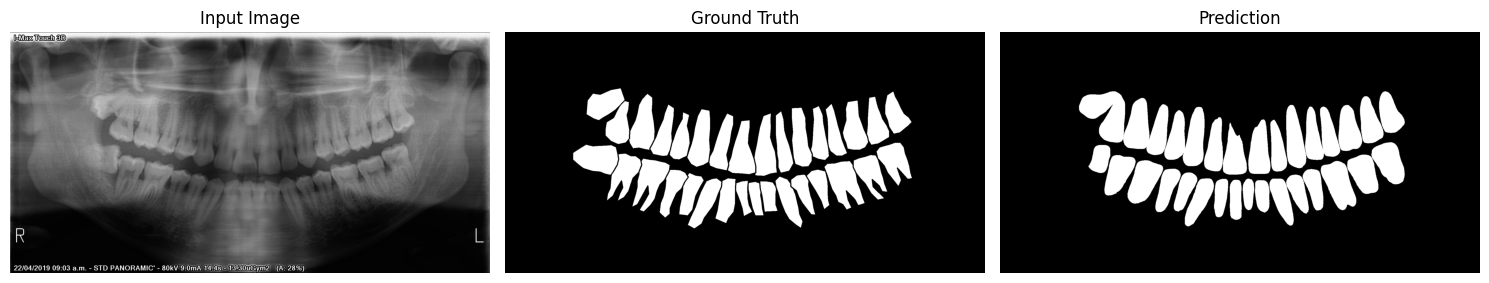

dice score 0.8671106929512377


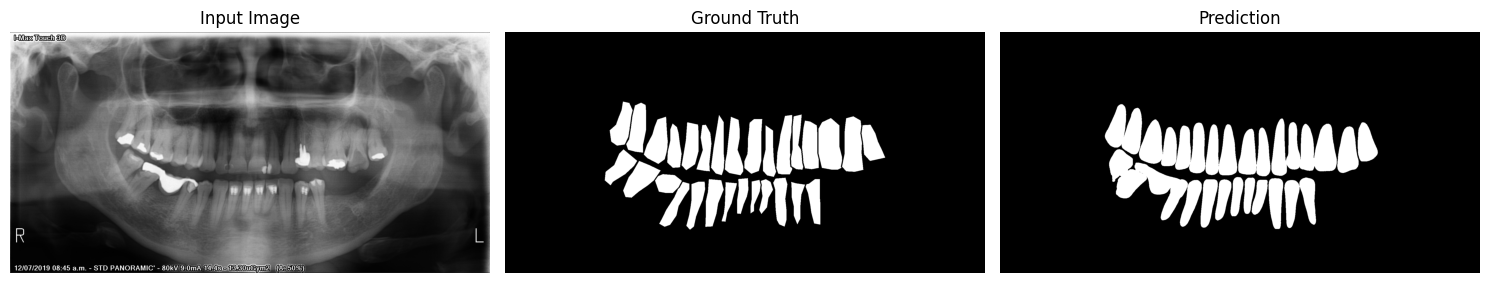

dice score 0.8545617027614553


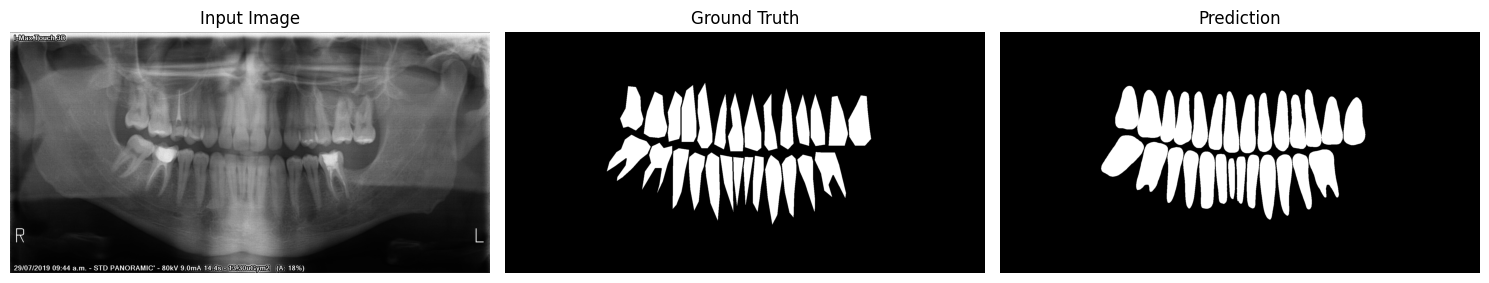

dice score 0.8714336632756834


In [37]:
from detectron2.utils.visualizer import ColorMode

dice_scores=[]
indexes_to_visualize=list(range(5))

for i in range(len(val_dir)):
  image_num=val_dir[i].split(".")[0]
  image_path = valid_images_path + "/" + val_dir[i]
  img = cv2.imread(image_path)
  img=cv2.resize(img, (2041, 1024))


  # Perform inference on the image
  outputs = predictor(img)

  # Get the predicted masks (shape: [N, H, W])
  pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()

  # Combine all masks into one (logical OR across masks)
  combined_mask = np.any(pred_masks, axis=0)

  # Convert the combined mask to a binary mask
  pred_binary_mask=combined_mask * 1

  # get the oringal mask for relvent image
  orig_mask_path=[mask_img for mask_img in mask_imgs_val_paths if mask_img.split("/")[-1].split(".")[0]==image_num ][0]
  orig_mask_arr=cv2.imread(orig_mask_path)

  # convert the oringal mask to binary mask
  orig_gray_mask = cv2.cvtColor(orig_mask_arr, cv2.COLOR_BGR2GRAY)
  _, orig_binary_mask = cv2.threshold(orig_gray_mask, 127, 1, cv2.THRESH_BINARY)

  # compute the dice score
  dice_score_val=dice_score(orig_binary_mask,pred_binary_mask)
  dice_scores.append(dice_score_val)


  # Visualize the results
  if i in indexes_to_visualize:
    visualize_predictions(img, orig_binary_mask, pred_binary_mask)
    print("dice score",dice_score_val)


In [38]:
# Calculate the average Dice score
average_dice = np.mean(dice_scores)
average_dice

0.8572992588054007